In [ ]:
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, Subset
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torchvision.models as models
from torch.utils.data.sampler import BatchSampler

необходимо загрузить в среду архив tar-формата. архитектура:

```
corn_only_tar.tar
└── corn_only/
    ├── 1-3 настоящих листа/
    │   ├── image_001.jpg
    │   ├── image_002.jpg
    │   ├── ...
    │   └── image_020.jpg
    │
    ├── 6-9 настоящих листьев/
    │   ├── image_001.jpg
    │   ├── image_002.jpg
    │   ├── ...
    │   └── image_020.jpg
    │
    ├── Восковая спелость/
    │   └── ...
    ├── Всходы/
    │   └── ...
    ├── Выбрасывание метёлки/
    │   └── ...
    ├── Молочная спелость/
    │   └── ...
    └── Молочно-восковая спелость/
        └── ...
```

Архитектура была протестирована на 20 картинках на класс, но чем их больше, тем лучше

Обязательно должно быть одинаковое количество картинок в каждом классе!!!

In [ ]:
!tar -xf corn_only_tar.tar

введите постоянные

In [ ]:
# обязательно надо поменять при изменении условий задачи (количество классов)
N_CLASSES = 7
ROOT_DIR = 'corn_only'
# не обязательно менять, но можно попробовать
EMBEDDING_DIM = 16 # просто, чтоб было удобно отобразить график на начальных стадиях исследования
examples_per_class_train = 16
examples_per_class_test = 4 # должны суммироваться в количество картинок на класс или в меньшее и относиться как 8:2
augmentations_per_image_train = 10
augmentations_per_image_test = 4
# количество примеров в выборке в итоге считается как N_CLASSES*examples_per_class*augmentations_per_image

max_pairs_per_class_test = min(1000, N_CLASSES *(augmentations_per_image_test*examples_per_class_test)*(augmentations_per_image_test*examples_per_class_test-1))
# Нормализация MobileNet -поменять только в случае изменения модели backbone
# в коде на ту, которая обучалась не на ImageNet
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [ ]:
class DatasetExtractor(Dataset):
    """Датасет для загрузки изображений из папок
      В этом же классе применяются изменения для картинок (torchvision.transform)
    """

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # Собираем все изображения и метки
        self.images = []
        self.labels = []
        self.class_to_idx = {}
        self.idx_to_class = {}

        # Считываем классы (названия папок)
        classes = sorted([d for d in os.listdir(root_dir)
                         if os.path.isdir(os.path.join(root_dir, d))])

        for idx, class_name in enumerate(classes):
            self.class_to_idx[class_name] = idx
            self.idx_to_class[idx] = class_name

            class_dir = os.path.join(root_dir, class_name)

            # Читаем все jpg файлы в папке класса
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(class_dir, img_name)
                    self.images.append(img_path)
                    self.labels.append(idx)

        print(f"Загружено {len(self.images)} изображений из {len(classes)} классов")
        print(f"Классы: {classes}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]

        # Открываем изображение
        img = Image.open(img_path).convert('RGB')

        # Применяем трансформации
        if self.transform:
            img = self.transform(img)

        return img, label

In [ ]:
class EmbeddingNet(nn.Module):
    def __init__(self, embedding_dim, freeze_backbone=True):
        super(EmbeddingNet, self).__init__()

        # Загружаем предобученную MobileNet_V3_Small и удаляем классификационный слой
        #  (224*224 вход и 576 выходной эмбеддинг)
        self.encoder = models.mobilenet_v3_small(pretrained=True)
        self.encoder.classifier = nn.Identity()

        # Замораживаем все слои (на всякий случай оставлю возможность разморозки через класс)
        if freeze_backbone:
            for param in self.encoder.parameters():
                param.requires_grad = False
            self.encoder.eval()  # Режим eval для BatchNorm/Dropout
        else:
            self.encoder.train()

        # Получаем размерность выхода энкодера (эмбеддинг)
        with torch.no_grad():
            test_input = torch.zeros(1, 3, 224, 224)
            feature_dim = self.encoder(test_input).size(1)

        # FC-слой для создания эмбеддингов
        self.fc = nn.Sequential(
            nn.Linear(feature_dim, 512),
            nn.BatchNorm1d(512),
            nn.PReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.PReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, embedding_dim)
        )

        print(f"Размер эмбеддинга из encoder: {feature_dim}")
        print(f"Backbone заморожен: {freeze_backbone}")

    def forward(self, x):
        # Извлекаем фичи
        if not next(self.encoder.parameters()).requires_grad:
          with torch.no_grad():
            features = self.encoder(x)
        else:
          features = self.encoder(x)

        features = features.view(features.size(0), -1)
        embeddings = self.fc(features)
        return embeddings

так как у нас мало данных, необходимо добавить много аугментаций (похоже на то как человек крутит фотографию и всматривается в особенности, чтоб лучше запомнить).

датасет разделяется на трейн и тест до аугментаций, поэтому предполагаем, что данные не просачиваются.

In [ ]:
def create_expanded_dataset_safe(full_dataset, n_classes, augmentations_per_image, examples_per_class=None, seed=42):
    """Создает расширенный датасет с аугментациями"""
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Если не указано examples_per_class, используем все доступные
    if examples_per_class is None:
        # Собираем статистику по классам
        class_counts = {i: 0 for i in range(n_classes)}
        for _, label in full_dataset:
            class_counts[label] += 1

        examples_per_class = min(class_counts.values())
        print(f"Автоматически определено examples_per_class = {examples_per_class}")

    # Собираем индексы для каждого класса
    class_indices = {i: [] for i in range(n_classes)}
    for idx, (_, label) in enumerate(full_dataset):
        class_indices[label].append(idx)

    # Выбираем примеры для каждого класса
    selected_indices = []
    for class_id in range(n_classes):
        indices = class_indices[class_id]
        if len(indices) > examples_per_class:
            selected = np.random.choice(indices, examples_per_class, replace=False)
        else:
            selected = indices
        selected_indices.extend(selected)

    # Создаем базовый Subset
    base_subset = Subset(full_dataset, selected_indices)

    expanded_data = []
    expanded_labels = []

    print(f"Создание расширенного датасета: {examples_per_class} примеров на класс × {n_classes} классов")

    for idx in range(len(base_subset)):
        img, label = base_subset[idx]

        # Сохраняем оригинальное изображение
        expanded_data.append(img)
        expanded_labels.append(label)

        # Добавляем аугментированные версии
        for i in range(augmentations_per_image - 1):
            # Случайные аугментации
            if np.random.random() > 0.5:
                aug_img = transforms.RandomHorizontalFlip(p=1.0)(img)
            else:
                aug_img = img

            # Случайный поворот
            angle = np.random.uniform(-15, 15)
            aug_img = transforms.functional.rotate(aug_img, angle)

            # Случайное изменение яркости/контраста
            brightness = np.random.uniform(0.8, 1.2)
            aug_img = transforms.functional.adjust_brightness(aug_img, brightness)

            expanded_data.append(aug_img)
            expanded_labels.append(label)

    class ExpandedDataset(Dataset):
        def __init__(self, data, labels, transform=None):
            self.data = data
            self.labels = labels
            self.transform = transform

        def __getitem__(self, index):
            img = self.data[index]
            label = self.labels[index]

            if self.transform:
                img = self.transform(img)

            return img, label

        def __len__(self):
            return len(self.data)

    return ExpandedDataset(expanded_data, expanded_labels, transform=None)

In [ ]:
# Трансформации для трейна
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Трансформации для теста
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

приступаем к обработке датасета

In [ ]:
# загрузка датасета
full_dataset = DatasetExtractor(root_dir=ROOT_DIR, transform=None)


Загружено 140 изображений из 7 классов
Классы: ['1-3 настоящих листа', '6-9 настоящих листьев', 'Восковая спелость', 'Всходы', 'Выбрасывание метёлки', 'Молочная спелость', 'Молочно-восковая спелость']


In [ ]:
# Разделяем на тренировочную и тестовую выборки
train_indices, test_indices = [], []
for class_idx in range(7):
    # Получаем все индексы для данного класса
    class_indices = [i for i, (_, label) in enumerate(full_dataset) if label == class_idx]

    # Разделяем 80/20 (16/4 из 20 изображений)
    train_class, test_class = train_test_split(
        class_indices, test_size=0.2, random_state=42
    )

    train_indices.extend(train_class)
    test_indices.extend(test_class)

# Создаем подвыборки
train_subset = Subset(full_dataset, train_indices)
test_subset = Subset(full_dataset, test_indices)

print(f"Тренировочная выборка: {len(train_subset)} изображений")
print(f"Тестовая выборка: {len(test_subset)} изображений")

Тренировочная выборка: 112 изображений
Тестовая выборка: 28 изображений


In [ ]:
# Создаем расширенные датасеты
expanded_train_dataset = create_expanded_dataset_safe(
    train_subset, n_classes=N_CLASSES, examples_per_class=examples_per_class_train,
    augmentations_per_image=augmentations_per_image_train
)
expanded_test_dataset = create_expanded_dataset_safe(
    test_subset, n_classes=N_CLASSES, examples_per_class=examples_per_class_test,
    augmentations_per_image=augmentations_per_image_test
)

# Применяем трансформации
expanded_train_dataset.transform = train_transform
expanded_test_dataset.transform = test_transform

print(f"Расширенный тренировочный датасет: {len(expanded_train_dataset)}")
print(f"Расширенный тестовый датасет: {len(expanded_test_dataset)}")

Создание расширенного датасета: 16 примеров на класс × 7 классов
Создание расширенного датасета: 4 примеров на класс × 7 классов
Расширенный тренировочный датасет: 1120
Расширенный тестовый датасет: 112


Это пока что просто датасеты с аугментациями, а не те, которые далее потребуются для обучения энкодера - они будут созданы в следующем коде.

**Идея**: на вход поступает не одна картинка, а две и сеть учится предсказывать принадлежат эти картинки к одному классу или к разным. Таким образом мы обучаем энкодер предсказывать хорошие разделимые эмбеддинги и в этом обучении почти квадратично расширяем выборку (если у нас было изначальных тренировочных 16 картинок на класс и расширенный датасет получался из 160 картинок на класс и всего имел 1120 примеров, то датасет из пар увеличивается квадратично 160 * 159 * 2 = 356160 пар (умножение на 2 - условие сбалансированной выборки)). после чего над этим энкодером надстраиваем классификатор на изначальные 7 классов

### Код для contrastive learning seamse network

In [ ]:
class SiameseDataset(Dataset):
    """Создаем датасет из пар картинок и одной меткой, означающей являются
    эти картинки одним классом или разными"""

    def __init__(self, dataset, max_pairs_per_class_test, is_train=True):
        self.dataset = dataset
        self.is_train = is_train

        # Получаем метки (индексу каждой картинки сопоставляем метку)
        self.labels = []
        for i in range(len(dataset)):
            img, label = dataset[i]
            self.labels.append(label)

        self.labels = torch.tensor(self.labels) # на месте с индексом картинки в датасете стоит метка этой картинки
        self.labels_set = set(self.labels.numpy()) # множество меток
        self.label_to_indices = {label: np.where(self.labels.numpy() == label)[0]
                                 for label in self.labels_set} # словарь, в котором каждой метке множества соответствуют индексы картинок с этой меткой
        # Заранее создаем для тестирования датасет с парами
        if not self.is_train:
            random_state = np.random.RandomState(29)
            positive_pairs = []
            negative_pairs = []

            # Для каждого класса создаем пары
            for label in self.labels_set:
                indices = self.label_to_indices[label]
                if len(indices) >= 2:
                    # Позитивные пары
                    for i in range(len(indices)):
                        for j in range(i+1, len(indices)):
                            positive_pairs.append([indices[i], indices[j], 1])


            # Негативные пары
            for label1 in self.labels_set:
                indices1 = self.label_to_indices[label1]
                other_labels = list(self.labels_set - set([label1]))

                for _ in range(int(0.5*(len(indices1)*(len(indices1)-1)))):
                    if indices1.size > 0 and other_labels:
                        idx1 = np.random.choice(indices1)
                        label2 = np.random.choice(other_labels)
                        indices2 = self.label_to_indices[label2]
                        if indices2.size > 0:
                            idx2 = np.random.choice(indices2)
                            negative_pairs.append([idx1, idx2, 0])

            all_pairs = positive_pairs + negative_pairs

            if len(all_pairs) > max_pairs_per_class_test:
                selected_indices = random_state.choice(len(all_pairs), max_pairs_per_class_test, replace=False)
                self.test_pairs = [all_pairs[i] for i in selected_indices]
            else:
                self.test_pairs = all_pairs
            cnt_pos = sum(pair[2] for pair in self.test_pairs)
            cnt_neg = len(self.test_pairs) - cnt_pos
            print(f"Создано тестовых пар: {len(self.test_pairs)} (положительных: {cnt_pos}, отрицательных: {cnt_neg})")

    def __getitem__(self, index):
      # для трейна!!!
      # на лету выбираем пару, чтоб не хранить в памяти все возможные пары
        if self.is_train:
            target = np.random.randint(0, 2)
            img1, label1 = self.dataset[index]
            label1 = label1.item() if torch.is_tensor(label1) else label1

            if target == 1:
                # Позитивная пара (здесь уже достаем сразу картинки, а не только индексами апеллируем)
                same_class_indices = self.label_to_indices[label1]
                # просто формальность, что класс не пустой
                if len(same_class_indices) < 2:
                    raise ValueError('Невозможно создать положительную пару при отсутствии других примеров в классе')
                # для обычного случая, который подозревается, что должен срабатывать всегда
                else:
                    siamese_index = index
                    while siamese_index == index:
                        siamese_index = np.random.choice(same_class_indices)
                    img2, _ = self.dataset[siamese_index]
            else:
                # Негативная пара
                other_labels = list(self.labels_set - set([label1]))
                if not other_labels:
                    raise ValueError("Невозможно создать отрицательную пару - нет информации о других классах")
                else:
                    siamese_label = np.random.choice(other_labels)
                    siamese_index = np.random.choice(self.label_to_indices[siamese_label])
                    img2, _ = self.dataset[siamese_index]
        else:
            # Тестовые пары
            if index >= len(self.test_pairs):
                # Если индекс выходит за пределы, берем последнюю пару
                # index = len(self.test_pairs) - 1
                raise ValueError('Проверьте формирование индексов для классов')
            img1, _ = self.dataset[self.test_pairs[index][0]]
            img2, _ = self.dataset[self.test_pairs[index][1]]
            target = self.test_pairs[index][2]

        return (img1, img2), target

    def __len__(self):
        if self.is_train:
            return len(self.dataset)
        else:
          # после if тоже просто формальность
            return len(self.test_pairs) if hasattr(self, 'test_pairs') else 0

In [ ]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss
    Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    Лосс как в SVM
    """

    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9

    def forward(self, output1, output2, target, size_average=True):
        distances = (output2 - output1).pow(2).sum(1)
        losses = 0.5 * (target.float() * distances +
                        (1 + -1 * target).float() * F.relu(self.margin - (distances + self.eps).sqrt()).pow(2))
        return losses.mean() if size_average else losses.sum()

In [ ]:
# переопределяем внешние метрики (Accuracy) под нашу задачу. просто для стабильности в вычислениях

class Metric:
    """стандартный абстрактный класс метрик, от которого будем наследовать (необходим,
    чтобы при необходимости изменить метрики или добавить навые, не удаляя другие классы)"""

    def __init__(self): pass
    def __call__(self, outputs, target, loss): raise NotImplementedError
    def reset(self): raise NotImplementedError
    def value(self): raise NotImplementedError
    def name(self): raise NotImplementedError


class AccumulatedAccuracyMetric(Metric):
    """
    Works with classification model
    """
    def __init__(self):
        self.correct = 0
        self.total = 0

    def __call__(self, outputs, target, loss):
        pred = outputs[0].data.max(1, keepdim=True)[1]
        self.correct += pred.eq(target[0].data.view_as(pred)).cpu().sum()
        self.total += target[0].size(0)
        return self.value()

    def reset(self):
        self.correct = 0
        self.total = 0

    def value(self):
        return 100 * float(self.correct) / self.total

    def name(self):
        return 'Accuracy'

In [ ]:
def train_epoch(train_loader, model, loss_fn, optimizer, cuda, log_interval, metrics):
    """
    Функция для обучения по одной эпохе
    """
    # обнуляем метрики с предыдущей эпохи и накапливаем новые
    for metric in metrics:
        metric.reset()

    # переводим модель в train
    model.train()
    losses = []
    total_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        target = target if len(target) > 0 else None
        # проверка на соответствие типа данных в dataloader
        if not type(data) in (tuple, list):
            data = (data,)
        #  при возможности переводим расчеты на GPU
        if cuda:
            data = tuple(d.cuda() for d in data)
            if target is not None:
                target = target.cuda()

        optimizer.zero_grad()
        # получаем выходы модели
        outputs = model(*data)

        if type(outputs) not in (tuple, list):
            outputs = (outputs,)

        # считаем лосс по по выходу
        loss_inputs = outputs
        if target is not None:
            target = (target,)
            loss_inputs += target

        loss_outputs = loss_fn(*loss_inputs)
        loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
        losses.append(loss.item())
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

        for metric in metrics:
            metric(outputs, target, loss_outputs)
        # выводим метрики в консоль
        if batch_idx % log_interval == 0:
            message = 'Train: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                batch_idx * len(data[0]), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), np.mean(losses))
            for metric in metrics:
                message += '\t{}: {}'.format(metric.name(), metric.value())

            print(message)
            losses = []

    total_loss /= (batch_idx + 1)
    return total_loss, metrics

In [ ]:
def test_epoch(val_loader, model, loss_fn, cuda, metrics):
    """
    подсчет метрик на тестовой выборке
    """
    with torch.no_grad():
        for metric in metrics:
            metric.reset()
        model.eval()
        val_loss = 0
        for batch_idx, (data, target) in enumerate(val_loader):
            target = target if len(target) > 0 else None
            if not type(data) in (tuple, list):
                data = (data,)
            if cuda:
                data = tuple(d.cuda() for d in data)
                if target is not None:
                    target = target.cuda()

            outputs = model(*data)

            if type(outputs) not in (tuple, list):
                outputs = (outputs,)
            loss_inputs = outputs
            if target is not None:
                target = (target,)
                loss_inputs += target

            loss_outputs = loss_fn(*loss_inputs)
            loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
            val_loss += loss.item()

            for metric in metrics:
                metric(outputs, target, loss_outputs)

    return val_loss, metrics

In [ ]:
def fit(train_loader, val_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[], start_epoch=0):
    for epoch in range(start_epoch, n_epochs):

        current_lr = optimizer.param_groups[0]['lr']
        # Train stage
        train_loss, metrics = train_epoch(train_loader, model, loss_fn, optimizer, cuda, log_interval, metrics)

        message = 'Epoch: {}/{}| LR: {}. Train loss: {:.4f}'.format(epoch + 1, n_epochs, current_lr, train_loss)
        for metric in metrics:
            message += '\t{}: {}'.format(metric.name(), metric.value())

        if val_loader is not None:
            val_loss, metrics = test_epoch(val_loader, model, loss_fn, cuda, metrics)
            val_loss /= len(val_loader)
            message += '\nEpoch: {}/{}. Validation loss: {:.4f}'.format(epoch + 1, n_epochs, val_loss)
            for metric in metrics:
                message += '\t{}: {}'.format(metric.name(), metric.value())
        # обновляем learning rate
        scheduler.step()

        print(message)

In [ ]:
class BalancedBatchSampler(BatchSampler):
    """
    создает батчи для нового классификатора на исходные 7 классов
    """
    def __init__(self, dataset, n_classes=7, n_samples=4):
        self.dataset = dataset
        self.labels = []

        # Получаем метки
        for i in range(len(dataset)):
            _, label = dataset[i] # если медленно работает, исправить здесь. обращение к генератору
            self.labels.append(label)

        self.labels = torch.tensor(self.labels)
        self.labels_set = list(set(self.labels.numpy()))
        self.label_to_indices = {label: np.where(self.labels.numpy() == label)[0]
                                 for label in self.labels_set}

        # Адаптируем количество классов (может быть меньше 7, если в батче)
        self.n_classes = min(n_classes, len(self.labels_set))
        self.n_samples = n_samples
        self.batch_size = self.n_samples * self.n_classes

        # Перемешиваем индексы в каждом классе
        for label in self.labels_set:
            np.random.shuffle(self.label_to_indices[label])

        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.n_dataset = len(self.labels)

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size <= self.n_dataset:
            # Выбираем случайные классы
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []

            for class_ in classes:
                start_idx = self.used_label_indices_count[class_]
                end_idx = start_idx + self.n_samples

                # Если достигли конца, начинаем заново
                if end_idx > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
                    start_idx = 0
                    end_idx = self.n_samples

                batch_indices = self.label_to_indices[class_][start_idx:end_idx]
                indices.extend(batch_indices)
                self.used_label_indices_count[class_] += self.n_samples

            yield indices
            self.count += self.batch_size

    def __len__(self):
        return self.n_dataset // self.batch_size

Переходим к сборке и запуску

In [ ]:
# Создаем сиамские датасеты
siamese_train_dataset = SiameseDataset(expanded_train_dataset, max_pairs_per_class_test, is_train=True)
siamese_test_dataset = SiameseDataset(expanded_test_dataset, max_pairs_per_class_test, is_train=False)

print(f"Сиамский тренировочный датасет: {len(siamese_train_dataset)} пар")
print(f"Сиамский тестовый датасет: {len(siamese_test_dataset)} пар")

Создано тестовых пар: 1000 (положительных: 489, отрицательных: 511)
Сиамский тренировочный датасет: 1120 пар
Сиамский тестовый датасет: 1000 пар


In [ ]:
# Настройка CUDA
cuda = torch.cuda.is_available()
kwargs = {'num_workers': 2, 'pin_memory': True} if cuda else {}
print(cuda)

True


In [ ]:
# Создаем DataLoader'ы

siamese_train_loader = torch.utils.data.DataLoader(
    siamese_train_dataset,
    batch_size=32,
    shuffle=True,
    **kwargs
)
siamese_test_loader = torch.utils.data.DataLoader(
    siamese_test_dataset, batch_size=32, shuffle=False, **kwargs
)


balanced_batch_sampler = BalancedBatchSampler(
    expanded_train_dataset, n_classes=N_CLASSES, n_samples=examples_per_class_test
)

In [ ]:
# Создаем модель
embedding_net = EmbeddingNet(
    embedding_dim=EMBEDDING_DIM,
    freeze_backbone=True
)

Размер эмбеддинга из encoder: 576
Backbone заморожен: True


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
class SiameseNet(nn.Module):
    def __init__(self, embedding_net):
        super(SiameseNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        return output1, output2
    # метод, с помощью которого после контрастного обучения сможем извлечь эмбеддинги
    def get_embedding(self, x):
        return self.embedding_net(x)

In [ ]:
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()

# Функция потерь и оптимизатор
margin = 1.0
loss_fn = ContrastiveLoss(margin)

# Оптимизируем только FC слой
optimizer = optim.Adam(embedding_net.fc.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8, last_epoch=-1)

# Обучение
n_epochs = 50
log_interval = 20

In [ ]:
print("Начинаем обучение...")
fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer,
    scheduler, n_epochs, cuda, log_interval)

Начинаем обучение...
Train: [0/1120 (0%)]	Loss: 1.396846
Train: [640/1120 (57%)]	Loss: 1.068902
Epoch: 1/50| LR: 0.001. Train loss: 0.8495
Epoch: 1/50. Validation loss: 0.1280
Train: [0/1120 (0%)]	Loss: 0.354998
Train: [640/1120 (57%)]	Loss: 0.368659
Epoch: 2/50| LR: 0.001. Train loss: 0.3408
Epoch: 2/50. Validation loss: 0.1003
Train: [0/1120 (0%)]	Loss: 0.223599
Train: [640/1120 (57%)]	Loss: 0.222697
Epoch: 3/50| LR: 0.001. Train loss: 0.2242
Epoch: 3/50. Validation loss: 0.0981
Train: [0/1120 (0%)]	Loss: 0.200358
Train: [640/1120 (57%)]	Loss: 0.173135
Epoch: 4/50| LR: 0.001. Train loss: 0.1715
Epoch: 4/50. Validation loss: 0.1043
Train: [0/1120 (0%)]	Loss: 0.204725
Train: [640/1120 (57%)]	Loss: 0.163679
Epoch: 5/50| LR: 0.001. Train loss: 0.1536
Epoch: 5/50. Validation loss: 0.0905
Train: [0/1120 (0%)]	Loss: 0.130827
Train: [640/1120 (57%)]	Loss: 0.131334
Epoch: 6/50| LR: 0.001. Train loss: 0.1285
Epoch: 6/50. Validation loss: 0.0949
Train: [0/1120 (0%)]	Loss: 0.135273
Train: [640/1

In [ ]:
def evaluate_model(model, dataloader, threshold=1.0):
    """Оценка точности модели"""
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for (img1, img2), targets in dataloader:
            if cuda:
                img1, img2 = img1.cuda(), img2.cuda()

            output1, output2 = model(img1, img2)
            distances = torch.norm(output1 - output2, dim=1)

            # Если расстояние меньше порога - предсказываем "один класс"
            predictions = (distances < threshold).float()
            correct += (predictions.cpu() == targets.float()).sum().item()
            total += len(targets)

    accuracy = 100.0 * correct / total
    print(f"Accuracy: {accuracy:.2f}% (threshold={threshold})")
    return accuracy

# Оцениваем модель
print("\nОценка на тестовом наборе:")
evaluate_model(model, siamese_test_loader, threshold=0.8)


Оценка на тестовом наборе:
Accuracy: 75.90% (threshold=0.8)


75.9

In [ ]:
# Извлекаем эмбеддинги
# создаем даталоадеры для датасета с исходными метками классоа
single_train_loader = torch.utils.data.DataLoader(
    expanded_train_dataset, batch_size=32, shuffle=True, **kwargs
)
single_test_loader = torch.utils.data.DataLoader(
    expanded_test_dataset, batch_size=32, shuffle=False, **kwargs
)

# Функция извлечения эмбеддингов
def extract_embeddings(dataloader, model):
    with torch.no_grad():
        # переводим в тестовый режим
        model.eval()
        all_embeddings = []
        all_labels = []

        for images, labels in dataloader:
            if cuda:
                images = images.cuda()

            embeddings = model.get_embedding(images)
            all_embeddings.append(embeddings.cpu().numpy())
            all_labels.append(labels.numpy())

        embeddings = np.vstack(all_embeddings)
        labels = np.concatenate(all_labels)

    return embeddings, labels


# для размерности эмбеддингов больше 2 будем использовать umap для
# отображения эмбеддингов в двумерное пространство
# при необходимости можно добавить другие способы отображения

from sklearn.decomposition import PCA
import umap
def extract_and_reduce_embeddings(dataloader, model, emb_dim, method='umap', reducer=None, is_train=True):
    embeddings, labels = extract_embeddings(dataloader, model)
    if reducer is None and is_train:
        if method=='umap':
            reducer = umap.UMAP(n_components=2, random_state=42)
        elif method=='pca':
            reducer = PCA(n_components=2, random_state=42)
        emb_2d = reducer.fit_transform(embeddings)

    elif reducer is not None and not is_train:
        emb_2d = reducer.transform(embeddings)

    return emb_2d, labels, reducer

In [ ]:
def plot_corn_embeddings(embeddings, targets, title="Corn Embeddings"):
    """Визуализация эмбеддингов для кукурузы"""
    plt.figure(figsize=(10, 8))

    # Цвета для 7 классов
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2']

    # Названия классов (предположительные)
    class_names = [f"Stage {i+1}" for i in range(7)]

    for i in range(7):
        inds = np.where(targets == i)[0]
        if len(inds) > 0:
            plt.scatter(embeddings[inds, 0], embeddings[inds, 1],
                       alpha=0.6, color=colors[i], label=class_names[i], s=50)

    plt.title(title, fontsize=14)
    plt.xlabel("Embedding Dimension 1", fontsize=12)
    plt.ylabel("Embedding Dimension 2", fontsize=12)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

In [ ]:
# если размер эмбеддинга 2, то можно еще этот код запустить

# # Получаем и визуализируем эмбеддинги
# train_embeddings, train_labels = extract_embeddings(single_train_loader, model)
# test_embeddings, test_labels = extract_embeddings(single_test_loader, model)

# # Рисуем
# plot_corn_embeddings(train_embeddings, train_labels, "Train Embeddings")
# plot_corn_embeddings(test_embeddings, test_labels, "Test Embeddings")

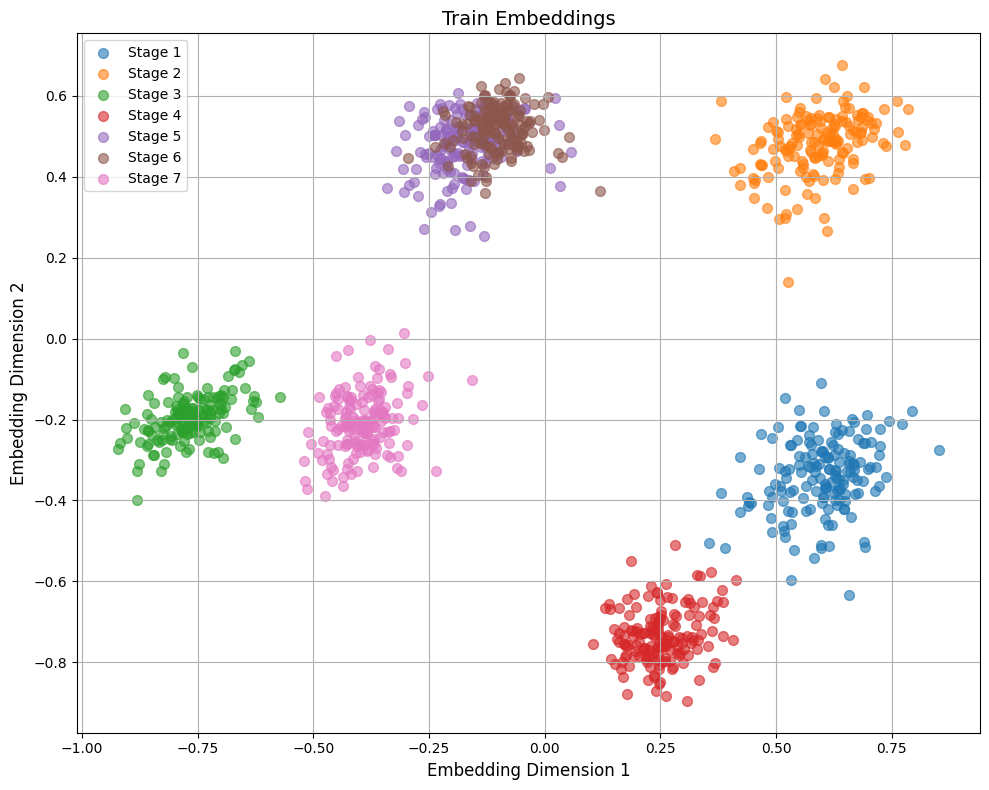

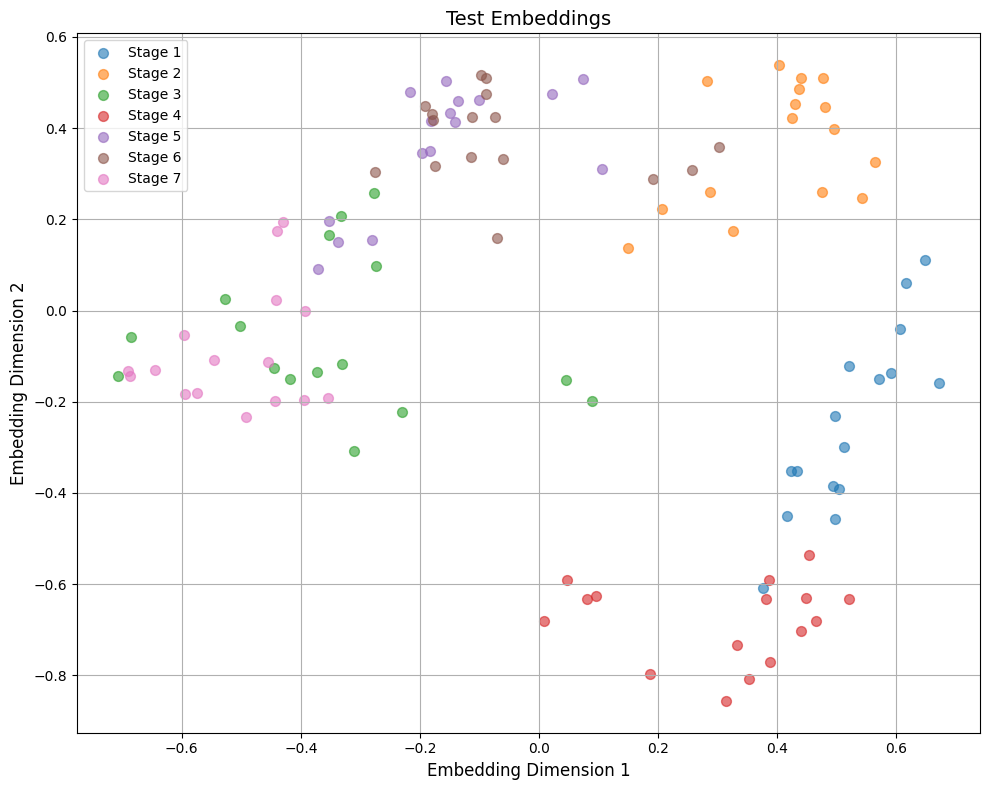

In [ ]:
train_embeddings, train_labels, reducer = extract_and_reduce_embeddings(single_train_loader, model, EMBEDDING_DIM, method='pca')
test_embeddings, test_labels, _ = extract_and_reduce_embeddings(single_test_loader, model, EMBEDDING_DIM, reducer=reducer, is_train=False, method='pca')
# Рисуем
plot_corn_embeddings(train_embeddings, train_labels, "Train Embeddings")
plot_corn_embeddings(test_embeddings, test_labels, "Test Embeddings")

Извлечем энкодер и проверим архитектуру (в начале должна быть огромная часть MobileNetV3, а в конце fc с 9 слоями)

In [ ]:
encoder = model.embedding_net
encoder

EmbeddingNet(
  (encoder): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (activation): ReLU()
            (scale_activation): Hardsigmoid()
          )
          (2): Con

In [ ]:
print("Энкодер заморожен?", all(not p.requires_grad for p in encoder.parameters()))

Энкодер заморожен? False


In [ ]:
for param in encoder.parameters():
    param.requires_grad = False
encoder.eval()
print("Энкодер заморожен?", all(not p.requires_grad for p in encoder.parameters()))

Энкодер заморожен? True


In [ ]:
class PlantPhaseClassifier(nn.Module):
    def __init__(self, encoder, num_classes, freeze_encoder=True):
        super().__init__()
        self.encoder = encoder
        self.is_freeze_enc = freeze_encoder

        # еще раз проверим, что энкодер заморожен и заморозим, если иначе (freeze_encoder показывает, что мы хотим, чтоб энкодер был заморожен)
        if freeze_encoder:
            for param in self.encoder.parameters():
                param.requires_grad = False

        self.classifier_for_phase = nn.Sequential(
            nn.Linear(EMBEDDING_DIM, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(32, num_classes),
            nn.Softmax()
        )

    def forward(self, x):
        # включает градиент в энкодер, если установлен режим train и энкодер намеренно разморожен
        # всегда пропускает внутрь, но с разными параметрами
        with torch.set_grad_enabled(self.training and not self.is_freeze_enc):
            embeddings = self.encoder(x)

        return self.classifier_for_phase(embeddings)

    def unfreeze_encoder(self):
      # чтобы разморозить энкодер, если понадобится fine-tuning
        self.is_freeze_enc = False
        for param in self.encoder.parameters():
            param.requires_grad = True
        self.encoder.train()

In [ ]:
classifier = PlantPhaseClassifier(encoder, num_classes=N_CLASSES)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

classifier.to(device)

optimizer = optim.AdamW(
    classifier.classifier_for_phase.parameters(),
    lr=1e-3,
    weight_decay=1e-2  # Сильная L2-регуляризация
)

criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

Using device: cuda


приступаем к обучению классификатора

In [ ]:
def train_classifier(model, train_loader, criterion, optimizer, device, epoch, log_interval=20):
    """Одна эпоха обучения классификатора"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        # Перенос на GPU
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Прямой проход (уже только через классификатор)
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Обратное распространение
        loss.backward()
        optimizer.step()

        # Статистика
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        if batch_idx % log_interval == 0:
            acc = 100. * correct / total
            avg_loss = total_loss / (batch_idx + 1)
            print(f'Epoch: {epoch} [{batch_idx}/{len(train_loader)}] '
                  f'Loss: {avg_loss:.4f} | Acc: {acc:.2f}%')

    return total_loss / len(train_loader), 100. * correct / total

def test_classifier(model, test_loader, criterion, device):
    """Тестирование классификатора"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_loss = total_loss / len(test_loader)
    accuracy = 100. * correct / total

    return avg_loss, accuracy

def fit_classifier(model, train_loader, test_loader, criterion, optimizer,
                   scheduler, epochs, device, log_interval=20):
    """Полный цикл обучения классификатора"""
    for epoch in range(epochs):
        # Обучение
        train_loss, train_acc = train_classifier(
            model, train_loader, criterion, optimizer, device, epoch+1, log_interval
        )

        # Валидация
        test_loss, test_acc = test_classifier(model, test_loader, criterion, device)

        # Обновление LR
        scheduler.step()

        # Вывод результатов
        print(f'\nEpoch: {epoch+1}/{epochs}')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%')
        print(f'LR: {optimizer.param_groups[0]["lr"]:.6f}')
        print('-' * 60)

In [ ]:
fit_classifier(
    model=classifier,
    train_loader=single_train_loader,
    test_loader=single_test_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=10,
    device=device,
    log_interval=20
)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1775: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: 1 [0/35] Loss: 1.9474 | Acc: 18.75%
Epoch: 1 [20/35] Loss: 1.8850 | Acc: 40.18%

Epoch: 1/10
Train Loss: 1.8402 | Train Acc: 49.73%
Test Loss: 1.8902 | Test Acc: 64.29%
LR: 0.000994
------------------------------------------------------------
Epoch: 2 [0/35] Loss: 1.6899 | Acc: 87.50%
Epoch: 2 [20/35] Loss: 1.6905 | Acc: 74.55%

Epoch: 2/10
Train Loss: 1.6664 | Train Acc: 77.14%
Test Loss: 1.7325 | Test Acc: 67.86%
LR: 0.000976
------------------------------------------------------------
Epoch: 3 [0/35] Loss: 1.6221 | Acc: 81.25%
Epoch: 3 [20/35] Loss: 1.5869 | Acc: 83.33%

Epoch: 3/10
Train Loss: 1.5649 | Train Acc: 85.36%
Test Loss: 1.6763 | Test Acc: 64.29%
LR: 0.000946
------------------------------------------------------------
Epoch: 4 [0/35] Loss: 1.5447 | Acc: 90.62%
Epoch: 4 [20/35] Loss: 1.4736 | Acc: 91.37%

Epoch: 4/10
Train Loss: 1.4551 | Train Acc: 92.32%
Test Loss: 1.6363 | Test Acc: 65.18%
LR: 0.000905
------------------------------------------------------------


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score, classification_report
import torch

def evaluate_and_visualize(model, train_loader, test_loader, device, embedding_dim=2):
    """
    Оценка точности и визуализация классификации
    """
    model.eval()

    def get_predictions(loader):
        """Получить предсказания и эмбеддинги из даталоадера"""
        all_preds = []
        all_labels = []
        all_embeddings = []

        with torch.no_grad():
            for images, labels in loader:
                images = images.to(device)

                # Получаем эмбеддинги через энкодер
                embeddings = model.encoder(images)
                # Получаем предсказания через классификатор
                outputs = model.classifier_for_phase(embeddings)
                _, preds = torch.max(outputs, 1)

                all_preds.append(preds.cpu().numpy())
                all_labels.append(labels.numpy())
                all_embeddings.append(embeddings.cpu().numpy())

        return (np.concatenate(all_preds),
                np.concatenate(all_labels),
                np.vstack(all_embeddings))

    # 1. Получаем предсказания для train и test
    print("Получение предсказаний для тренировочного датасета...")
    train_preds, train_labels, train_emb = get_predictions(train_loader)

    print("Получение предсказаний для тестового датасета...")
    test_preds, test_labels, test_emb = get_predictions(test_loader)

    # 2. Вычисляем accuracy
    train_acc = accuracy_score(train_labels, train_preds)
    test_acc = accuracy_score(test_labels, test_preds)

    print("=" * 50)
    print("РЕЗУЛЬТАТЫ КЛАССИФИКАЦИИ:")
    print("=" * 50)
    print(f"Тренировочный датасет (expanded_train_dataset):")
    print(f"  Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
    print(f"  Размер: {len(train_labels)} примеров")
    print()
    print(f"Тестовый датасет (expanded_test_dataset):")
    print(f"  Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
    print(f"  Размер: {len(test_labels)} примеров")
    print("=" * 50)

    # 3. Classification report
    print("\nДЕТАЛЬНЫЙ ОТЧЕТ ПО КЛАССАМ (Test):")
    print(classification_report(test_labels, test_preds,
                                target_names=[f'Stage {i+1}' for i in range(7)]))

    # 4. Визуализация областей решений (только если embedding_dim=2)
    if embedding_dim == 2:
        _plot_decision_regions(model, train_emb, train_labels, train_preds,
                              test_emb, test_labels, test_preds, device)
    else:
        print(f"\nПримечание: embedding_dim={embedding_dim}, визуализация возможна только для 2D")

    return train_acc, test_acc, train_emb, test_emb

def _plot_decision_regions(model, train_emb, train_labels, train_preds,
                          test_emb, test_labels, test_preds, device):
    """
    Визуализация областей решений в 2D пространстве эмбеддингов
    """
    # Создаем сетку для отрисовки областей
    # Расширяем границы для лучшей визуализации
    all_emb = np.vstack([train_emb, test_emb])
    x_min, x_max = all_emb[:, 0].min() - 0.5, all_emb[:, 0].max() + 0.5
    y_min, y_max = all_emb[:, 1].min() - 0.5, all_emb[:, 1].max() + 0.5

    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, 0.02),  # Шаг сетки
        np.arange(y_min, y_max, 0.02)
    )

    # Предсказываем классы для каждой точки сетки
    print("Построение карты решений...")
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_tensor = torch.FloatTensor(grid_points).to(device)

    with torch.no_grad():
        # Пропускаем через классификатор (минуя энкодер, так как у нас уже эмбеддинги)
        grid_outputs = model.classifier_for_phase(grid_tensor)
        grid_preds = torch.argmax(grid_outputs, dim=1)
        Z = grid_preds.cpu().numpy().reshape(xx.shape)

    # Цвета для 7 классов (пастельные тона для лучшей различимости)
    colors = ['#FF9999', '#99FF99', '#9999FF', '#FFFF99',
              '#FF99FF', '#99FFFF', '#FFCC99']
    cmap = ListedColormap(colors[:7])

    # Создаем фигуру с 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # График 1: Области решений
    ax1 = axes[0]
    # Заливаем области разными цветами
    contour = ax1.contourf(xx, yy, Z, alpha=0.5, cmap=cmap, levels=np.arange(8)-0.5)
    # Добавляем контуры между областями
    ax1.contour(xx, yy, Z, colors='k', linewidths=0.3, alpha=0.8, levels=np.arange(8)-0.5)

    ax1.set_xlabel('Embedding Dimension 1', fontsize=11)
    ax1.set_ylabel('Embedding Dimension 2', fontsize=11)
    ax1.set_title('Decision Regions (Области решений классификатора)', fontsize=12, pad=12)
    ax1.grid(True, alpha=0.2, linestyle='--')

    # График 2: Тренировочные данные на карте решений
    ax2 = axes[1]
    # Фон - области решений
    ax2.contourf(xx, yy, Z, alpha=0.3, cmap=cmap, levels=np.arange(8)-0.5)

    # Отрисовываем точки тренировочных данных
    markers = ['o', 's', '^', 'D', 'v', '<', '>']  # Разные маркеры для классов

    for i in range(7):
        mask = train_labels == i
        if np.any(mask):
            ax2.scatter(train_emb[mask, 0], train_emb[mask, 1],
                       c=colors[i], s=40, marker=markers[i],
                       edgecolors='k', linewidth=0.7,
                       label=f'Stage {i+1} (train)', alpha=0.9)

    ax2.set_xlabel('Embedding Dimension 1', fontsize=11)
    ax2.set_ylabel('Embedding Dimension 2', fontsize=11)
    ax2.set_title('Train Data on Decision Map\n(Тренировочные данные)', fontsize=12, pad=12)
    ax2.legend(loc='best', fontsize=9, ncol=2)
    ax2.grid(True, alpha=0.2, linestyle='--')

    # График 3: Тестовые данные на карте решений
    ax3 = axes[2]
    # Фон - области решений
    ax3.contourf(xx, yy, Z, alpha=0.3, cmap=cmap, levels=np.arange(8)-0.5)

    # Отрисовываем точки тестовых данных
    for i in range(7):
        mask = test_labels == i
        if np.any(mask):
            ax3.scatter(test_emb[mask, 0], test_emb[mask, 1],
                       c=colors[i], s=60, marker=markers[i],
                       edgecolors='k', linewidth=1.2,
                       label=f'Stage {i+1} (test)', alpha=1.0)

            # Подписываем неправильно классифицированные точки
            test_class_preds = test_preds[test_labels == i]
            test_class_emb = test_emb[test_labels == i]
            wrong_mask = test_class_preds != i

            if np.any(wrong_mask):
                ax3.scatter(test_class_emb[wrong_mask, 0], test_class_emb[wrong_mask, 1],
                           facecolors='none', s=100, marker='X',
                           edgecolors='red', linewidth=2.0,
                           label=f'Wrong (Stage {i+1})' if i == 0 else "")

    ax3.set_xlabel('Embedding Dimension 1', fontsize=11)
    ax3.set_ylabel('Embedding Dimension 2', fontsize=11)
    ax3.set_title('Test Data on Decision Map\n(Тестовые данные, красный X = ошибка)', fontsize=12, pad=12)
    ax3.legend(loc='best', fontsize=9, ncol=2)
    ax3.grid(True, alpha=0.2, linestyle='--')

    plt.tight_layout()
    plt.show()

    # 5. Дополнительная визуализация: матрица ошибок
    fig2, axes2 = plt.subplots(1, 2, figsize=(12, 5))

    # Гистограмма распределения классов в train
    ax1 = axes2[0]
    unique_train, counts_train = np.unique(train_labels, return_counts=True)
    ax1.bar(unique_train, counts_train, color=colors, edgecolor='black')
    ax1.set_xlabel('Class', fontsize=11)
    ax1.set_ylabel('Count', fontsize=11)
    ax1.set_title('Distribution of Classes in Train Set', fontsize=12)
    ax1.set_xticks(range(7))
    ax1.set_xticklabels([f'Stage {i+1}' for i in range(7)])

    # Матрица ошибок для теста
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(test_labels, test_preds)

    ax2 = axes2[1]
    im = ax2.imshow(cm, cmap='Blues', interpolation='nearest')

    # Добавляем значения в ячейки
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color = 'white' if cm[i, j] > cm.max() / 2 else 'black'
            ax2.text(j, i, str(cm[i, j]),
                    ha='center', va='center',
                    color=color, fontsize=10)

    ax2.set_xlabel('Predicted Label', fontsize=11)
    ax2.set_ylabel('True Label', fontsize=11)
    ax2.set_title('Confusion Matrix (Test)', fontsize=12)
    ax2.set_xticks(range(7))
    ax2.set_yticks(range(7))
    ax2.set_xticklabels([f'S{i+1}' for i in range(7)])
    ax2.set_yticklabels([f'S{i+1}' for i in range(7)])
    plt.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

# ========== ЗАПУСК ОЦЕНКИ ==========

print("Начинаем оценку классификатора...")
print(f"Embedding Dimension: {EMBEDDING_DIM}")

# Полная оценка с визуализацией
print("\n" + "="*60)
print("ПОЛНАЯ ОЦЕНКА С ВИЗУАЛИЗАЦИЕЙ:")
print("="*60)
train_acc, test_acc, train_emb, test_emb = evaluate_and_visualize(
    classifier,
    single_train_loader,
    single_test_loader,
    device,
    embedding_dim=EMBEDDING_DIM
)

# 6. Анализ ошибок на основе полученных данных
print("\n" + "="*60)
print("АНАЛИЗ ОШИБОК:")
print("="*60)

# Получаем тестовые предсказания еще раз для анализа (уже есть из evaluate_and_visualize)
# Перезагрузим для уверенности
classifier.eval()
test_predictions = []
test_true_labels = []

with torch.no_grad():
    for images, labels in single_test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = classifier(images)
        _, preds = torch.max(outputs, 1)

        test_predictions.append(preds.cpu().numpy())
        test_true_labels.append(labels.cpu().numpy())

test_predictions = np.concatenate(test_predictions)
test_true_labels = np.concatenate(test_true_labels)

# Находим неправильные предсказания
wrong_indices = np.where(test_predictions != test_true_labels)[0]

if len(wrong_indices) > 0:
    print(f"Найдено {len(wrong_indices)} ошибок из {len(test_true_labels)} тестовых примеров")
    print(f"Процент ошибок: {len(wrong_indices)/len(test_true_labels)*100:.2f}%")

    # Анализ по классам
    print("\nАнализ ошибок по классам:")
    for i in range(7):
        class_indices = np.where(test_true_labels == i)[0]
        if len(class_indices) > 0:
            class_wrong = np.sum(test_predictions[class_indices] != test_true_labels[class_indices])
            print(f"  Stage {i+1}: {class_wrong}/{len(class_indices)} ошибок ({class_wrong/len(class_indices)*100:.1f}%)")

    # Какие классы чаще всего путаются
    from collections import Counter
    error_pairs = [(true, pred) for true, pred in zip(test_true_labels[wrong_indices],
                                                     test_predictions[wrong_indices])]
    most_common_errors = Counter(error_pairs).most_common(5)

    print("\nНаиболее частые ошибки (True → Predicted):")
    for (true, pred), count in most_common_errors:
        print(f"  Stage {true+1} → Stage {pred+1}: {count} раз")

        # Попробуем понять, почему
        if (true, pred) in [(4, 2), (4, 3), (2, 3), (3, 2)]:  # Примеры из вашего classification report
            print(f"     * Вероятно, Stage {true+1} и Stage {pred+1} имеют схожие визуальные признаки")

else:
    print("Поздравляю! Все тестовые примеры классифицированы правильно!")

Начинаем оценку классификатора...
Embedding Dimension: 16

ПОЛНАЯ ОЦЕНКА С ВИЗУАЛИЗАЦИЕЙ:
Получение предсказаний для тренировочного датасета...
Получение предсказаний для тестового датасета...
РЕЗУЛЬТАТЫ КЛАССИФИКАЦИИ:
Тренировочный датасет (expanded_train_dataset):
  Accuracy: 0.9973 (99.73%)
  Размер: 1120 примеров

Тестовый датасет (expanded_test_dataset):
  Accuracy: 0.6607 (66.07%)
  Размер: 112 примеров

ДЕТАЛЬНЫЙ ОТЧЕТ ПО КЛАССАМ (Test):
              precision    recall  f1-score   support

     Stage 1       0.88      0.94      0.91        16
     Stage 2       0.89      1.00      0.94        16
     Stage 3       0.33      0.31      0.32        16
     Stage 4       0.88      0.88      0.88        16
     Stage 5       0.50      0.75      0.60        16
     Stage 6       0.70      0.44      0.54        16
     Stage 7       0.42      0.31      0.36        16

    accuracy                           0.66       112
   macro avg       0.66      0.66      0.65       112
weighted 

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1775: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


проверим на фотке

In [ ]:
# название фазы → номер
name_to_id = full_dataset.class_to_idx

# номер → название фазы
id_to_name = full_dataset.idx_to_class

In [ ]:
id_to_name

{0: '1-3 настоящих листа',
 1: '6-9 настоящих листьев',
 2: 'Восковая спелость',
 3: 'Всходы',
 4: 'Выбрасывание метёлки',
 5: 'Молочная спелость',
 6: 'Молочно-восковая спелость'}

In [ ]:
image_path = 'Screenshot 2025-12-13 180301.png'
transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Ресайз до 224x224
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    # Загрузка и преобразование изображения
image = Image.open(image_path).convert('RGB')
image_tensor = transform(image).unsqueeze(0).to(device)  # [1, 3, 224, 224]

classifier.eval()
with torch.no_grad():
        probabilities = classifier(image_tensor)
        predicted_class = torch.argmax(probabilities, dim=1).item()

    # Преобразуем в numpy для удобства
probabilities = probabilities.squeeze().cpu().numpy()

    # Вывод результатов
print(f"\n{'='*60}")
print(f"РЕЗУЛЬТАТ КЛАССИФИКАЦИИ:")
print(f"Изображение: {image_path}")
print(f"Предсказанная фаза: {id_to_name[predicted_class]}")
print(probabilities)


РЕЗУЛЬТАТ КЛАССИФИКАЦИИ:
Изображение: Screenshot 2025-12-13 180301.png
Предсказанная фаза: 6-9 настоящих листьев
[0.02311798 0.940314   0.00138771 0.00257968 0.0243833  0.0033017
 0.00491568]


In [ ]:
for i, phase_prob in enumerate(probabilities):
  print(f'{id_to_name[i]}: {phase_prob}')

1-3 настоящих листа: 0.02311798185110092
6-9 настоящих листьев: 0.940313994884491
Восковая спелость: 0.0013877092860639095
Всходы: 0.002579678315669298
Выбрасывание метёлки: 0.024383295327425003
Молочная спелость: 0.003301695454865694
Молочно-восковая спелость: 0.004915683064609766


In [ ]:
!pip install onnxscript onnx onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 683.0/683.0 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 115.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 98.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.3/129.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.0 MB/s eta 0:00:00


In [ ]:
# Экспорт в ONNX

torch.onnx.dynamo_export = False  # Отключаем dynamo

# 2. Экспорт с opset_version=18 (как рекомендует система)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
classifier.to(device).eval()

dummy_input = torch.randn(1, 3, 224, 224).to(device)

torch.onnx.export(
    classifier,
    dummy_input,
    "plant_classifier_emb16.onnx",
    export_params=True,
    opset_version=18,
    input_names=['input'],
    output_names=['output'],
)

print("✓ Модель сохранена как plant_classifier_emb16.onnx")


[torch.onnx] Obtain model graph for `PlantPhaseClassifier([...]` with `torch.export.export(..., strict=False)`...


/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:2127: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return handle_torch_function(


[torch.onnx] Obtain model graph for `PlantPhaseClassifier([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 73 of general pattern rewrite rules.
✓ Модель сохранена как plant_classifier_emb16.onnx
